## VGG16 Model. All categories

For this notebook pretrained Vgg16 model will be used to predict the 8 categories of images.

### 00. Load libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 01. Load images
The images are separated into train, test and validation using the function of keras call image_dataset_from_directory

In [ ]:
train_dir = './labeled-images/train'
test_dir = './labeled-images/test'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 100
#EPOCHS = 5

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
# Creating generators (prepare data to feed the model)
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 5752 files belonging to 8 classes.
Using 4602 files for training.
Found 5752 files belonging to 8 classes.
Using 1150 files for validation.
Found 640 files belonging to 8 classes.


### 02. Model architecture

Loading of pretrained VGG16 model with imagenet and creation of the architecture.

In [ ]:
pretrained = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))

model.add(pretrained)

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(8))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 264, 264, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 activation (Activation)     (None, 8)                 0

### 03. Weight adjustment
As observed in the EDA, the classes were not balanced. In order for the model not to over-train, higher weights are given to those classes with fewer samples.

In [ ]:
cat_list = os.listdir('./labeled-images/train/')
cat_list.sort()

lenghts = [len(os.listdir('./labeled-images/train/'+cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.sqrt(np.round(1/(np.array(lenghts) / total_train_images),2)))

print(cat_list)
print(lenghts)
print(weights)

['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
[239, 264, 1447, 256, 115, 209, 2585, 637]
[4.906118628814432, 4.6679760067935225, 1.9949937343260002, 4.740253157796532, 7.07248188403477, 5.2459508194416005, 1.493318452306808, 3.004995840263344]


### 04. Model train
We add earlystopping in order to keep the best model. If the model gets worse with increasing iterations, we will keep the best one.

For the learning_rate, a small value (0.001) is set so that the different combinations of parameters can be correctly explored until the optimum is reached.

The number of epochs was set at 100 in order to appreciate the evolution of the model during training.

In [ ]:
patience = 20

#early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

In [ ]:
# freeze vgg16
pretrained.trainable = False

model.compile(loss='categorical_crossentropy', loss_weights=weights,
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# Training
history = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // BATCH_SIZE,
    verbose=1,
    callbacks = [early_stopping])

Epoch 1/100
4/4 [==============================] - 337s 73s/step - loss: 21.7885 - accuracy: 0.2422 - val_loss: 23.5541 - val_accuracy: 0.4375
Epoch 2/100
4/4 [==============================] - 113s 30s/step - loss: 28.4890 - accuracy: 0.2500 - val_loss: 32.1077 - val_accuracy: 0.1250
Epoch 3/100
4/4 [==============================] - 111s 30s/step - loss: 16.0422 - accuracy: 0.3672 - val_loss: 16.9142 - val_accuracy: 0.1875
Epoch 4/100
4/4 [==============================] - 111s 30s/step - loss: 14.5666 - accuracy: 0.3203 - val_loss: 11.3766 - val_accuracy: 0.4688
Epoch 5/100
4/4 [==============================] - 112s 30s/step - loss: 10.4868 - accuracy: 0.3750 - val_loss: 8.8185 - val_accuracy: 0.2188
Epoch 6/100
4/4 [==============================] - 111s 30s/step - loss: 8.1220 - accuracy: 0.3672 - val_loss: 9.5241 - val_accuracy: 0.3438
Epoch 7/100
4/4 [==============================] - 111s 30s/step - loss: 7.7525 - accuracy: 0.4531 - val_loss: 8.4906 - val_accuracy: 0.4062
Epoc

In [ ]:
model.save('vgg16-100epoch-freeze.h5')

### 05. Analysis of results

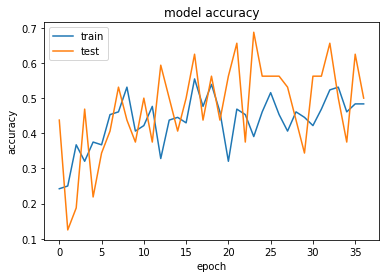

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Throughout the training it is observed that the trend of the accuracy is increasing, so it seems that it is learning, although the values it takes are very low and therefore it is not a valid model.

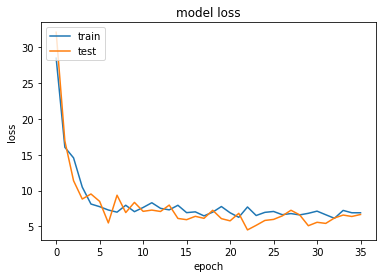

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The evolution of the loss is very good since it decreases throughout the training and the value it takes is low. In spite of this, as mentioned above, the accuracy is low.

In [ ]:
model = load_model('vgg16-100epoch-freeze.h5')

In [ ]:
## Predict on test data
y_pred = model.predict(test_generator)

In [ ]:
test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

In [ ]:
y_pred_class = y_pred.argmax(axis=1)

In [ ]:
y_real_class = y_real.argmax(axis=1)

Text(33.0, 0.5, 'Truth')

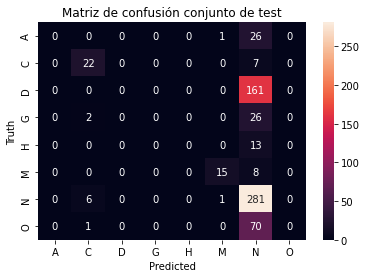

In [ ]:
labels = ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']

cf_matrix = confusion_matrix(y_real_class, y_pred_class)
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d')
plt.title('Matriz de confusión conjunto de test')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In this case, Cataract and Myopia are detected with quite good precission. 

In spite of this, many images are classified in the normal class that do not correspond to this class and therefore this model could not be considered valid.

In [ ]:
print(classification_report(y_real_class, y_pred_class, target_names=labels))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        27
           C       0.71      0.76      0.73        29
           D       0.00      0.00      0.00       161
           G       0.00      0.00      0.00        28
           H       0.00      0.00      0.00        13
           M       0.88      0.65      0.75        23
           N       0.47      0.98      0.64       288
           O       0.00      0.00      0.00        71

    accuracy                           0.50       640
   macro avg       0.26      0.30      0.27       640
weighted avg       0.28      0.50      0.35       640



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
